# Mapping Collisions to Junctions

__Last update: November 2022__

This builds on the junction data built in `junctions-graph.ipynb` and stored in the `../data/junctions.csv` csv.

This maps collisions onto the junctions.

In [244]:
import geopandas
import pandas as pd
import seaborn as sns
import contextily as cx
import matplotlib.pyplot as plt

from sklearn.neighbors import BallTree
from ipyleaflet import Map, Marker, basemaps

sns.set(
    context='notebook',
    style='white',
    palette='Set1',
    font_scale=.9,
    font='monospace'
)

In [245]:
def get_nearest_junction(row, tree):
    '''
    Find nearest junction to crash / collision. Return distance and the index for junction
    '''
    crash_coordinate = row[['latitude', 'longitude']].values
    result = tree.query([crash_coordinate])

    distance = result[0][0][0]  # result is weirdly nested
    index = result[1][0][0]
    return distance, index

# 1. Read in collision data

`../data/london-crashes.csv` filter to serious and fatal collisions only.

In [246]:
# not a massive fan of the use of the term 'accidents'
collisions = pd.read_csv('../data/collision-data/london-crashes.csv')

collisions.rename(columns={'accident_index': 'id'}, inplace=True)

collisions = collisions[collisions['max_cyclist_severity'] != 'slight']

# example rows
collisions.head()

,id,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,datetime,fatal_cyclist_casualties,serious_cyclist_casualties,slight_cyclist_casualties,danger_metric,recency_danger_metric,max_cyclist_severity
10,201101BS70212,2011,01BS70212,526820.0,177800.0,-0.174917,51.484887,Metropolitan Police,Serious,2,...,Yes,Non-trunk,E01002845,2011-05-23T06:19:00Z,0,1,0,1,0.0,serious
13,201101BS70227,2011,01BS70227,527690.0,179150.0,-0.161906,51.496824,Metropolitan Police,Serious,2,...,Yes,Non-trunk,E01002818,2011-05-24T07:23:00Z,0,1,0,1,0.0,serious
25,201101BS70277,2011,01BS70277,524710.0,180260.0,-0.204421,51.507464,Metropolitan Police,Serious,2,...,Yes,Non-trunk,E01002871,2011-06-22T06:30:00Z,0,1,0,1,0.0,serious
37,201101BS70328,2011,01BS70328,524640.0,181190.0,-0.205100,51.515838,Metropolitan Police,Serious,2,...,Yes,Non-trunk,E01002831,2011-07-19T21:12:00Z,0,1,0,1,0.0,serious
38,201101BS70329,2011,01BS70329,524700.0,180500.0,-0.204480,51.509624,Metropolitan Police,Serious,2,...,Yes,Non-trunk,E01002875,2011-07-05T06:15:00Z,0,1,0,1,0.0,serious


# 2. Load in junction data

`../data/junctions.csv`

In [292]:
junctions = pd.read_csv('../data/junctions.csv')

junctions.head()

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster
0,0,78112,51.526976,-0.145792,0.0,51.526889,-0.145788
1,1,99936,51.523611,-0.152791,2.0,51.523752,-0.152795
2,2,99937,51.523018,-0.152024,3.0,51.523211,-0.151568
3,3,101818,51.535179,-0.148104,4.0,51.535179,-0.148104
4,4,101831,51.535612,-0.147044,6.0,51.536714,-0.146606


# 3. Find nearest junction to each collision

Use BallTree algorithm.

Havesine distance since these are coordinates.

In [248]:
tree = BallTree(junctions[['latitude_junction', 'longitude_junction']], metric='haversine')

collisions[['distance_to_junction', 'junction_index']] = collisions.apply(
    lambda row: get_nearest_junction(row, tree), axis=1, result_type='expand'
)

# join to get junction ids
collisions = collisions.merge(
    junctions[['junction_index', 'junction_id']],
    how='left',
    on='junction_index'
)

collisions.head()

,id,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,datetime,fatal_cyclist_casualties,serious_cyclist_casualties,slight_cyclist_casualties,danger_metric,recency_danger_metric,max_cyclist_severity,distance_to_junction,junction_index,junction_id
0,201101BS70212,2011,01BS70212,526820.0,177800.0,-0.174917,51.484887,Metropolitan Police,Serious,2,...,2011-05-23T06:19:00Z,0,1,0,1,0.0,serious,0.000076,14448.0,27512727
1,201101BS70227,2011,01BS70227,527690.0,179150.0,-0.161906,51.496824,Metropolitan Police,Serious,2,...,2011-05-24T07:23:00Z,0,1,0,1,0.0,serious,0.000124,12344.0,26592979
2,201101BS70277,2011,01BS70277,524710.0,180260.0,-0.204421,51.507464,Metropolitan Police,Serious,2,...,2011-06-22T06:30:00Z,0,1,0,1,0.0,serious,0.000076,40618.0,3936955037
3,201101BS70328,2011,01BS70328,524640.0,181190.0,-0.205100,51.515838,Metropolitan Police,Serious,2,...,2011-07-19T21:12:00Z,0,1,0,1,0.0,serious,0.000079,2054.0,275440
4,201101BS70329,2011,01BS70329,524700.0,180500.0,-0.204480,51.509624,Metropolitan Police,Serious,2,...,2011-07-05T06:15:00Z,0,1,0,1,0.0,serious,0.000041,44417.0,7342416727


### Look at distance to junction distribution

Will filter out any too far away from junction, `>.001`

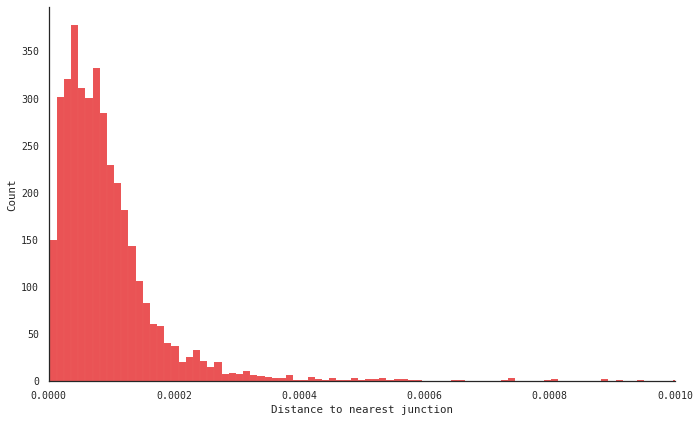

In [249]:
sns.displot(
    collisions.distance_to_junction,
    height=6,
    aspect=1.6
)
plt.xlim(0, .001)
plt.xlabel('Distance to nearest junction');

## Combine dataset for aggregation

In [250]:
distance_threshold = .001

junction_collisions = (
    junctions
    .merge(
        collisions,
        how='left',
        on=['junction_id', 'junction_index']
    )
)

junction_collisions = junction_collisions[
    junction_collisions['distance_to_junction'] <= distance_threshold
]

junction_collisions.head()

,junction_index,junction_id,latitude_junction,longitude_junction,junction_cluster_id,latitude_cluster,longitude_cluster,id,accident_year,accident_reference,...,trunk_road_flag,lsoa_of_accident_location,datetime,fatal_cyclist_casualties,serious_cyclist_casualties,slight_cyclist_casualties,danger_metric,recency_danger_metric,max_cyclist_severity,distance_to_junction
1,1,99936,51.523611,-0.152791,2.0,51.523752,-0.152795,2017010052586,2017.0,010052586,...,Non-trunk,E01004716,2017-08-08T09:08:00Z,0.0,1.0,0.0,1.0,0.845098,serious,0.000018
3,3,101818,51.535179,-0.148104,4.0,51.535179,-0.148104,2019010213191,2019.0,010213191,...,Non-trunk,E01000948,2019-10-21T18:00:00Z,0.0,1.0,0.0,1.0,0.954243,serious,0.000018
4,4,101831,51.535612,-0.147044,6.0,51.536714,-0.146606,2018010119967,2018.0,010119967,...,Non-trunk,E01000948,2018-07-10T06:58:00Z,0.0,1.0,0.0,1.0,0.903090,serious,0.000069
6,6,101842,51.534054,-0.162657,11.0,51.534054,-0.162657,201401CW10198,2014.0,01CW10198,...,Non-trunk,E01004727,2014-02-22T08:15:00Z,0.0,1.0,0.0,1.0,0.602060,serious,0.000028
7,6,101842,51.534054,-0.162657,11.0,51.534054,-0.162657,2019010203890,2019.0,010203890,...,Non-trunk,E01004727,2019-09-07T09:10:00Z,0.0,1.0,0.0,1.0,0.954243,serious,0.000052


## Aggregate data

To the junction cluster level

In [280]:
top_n = 20

junction_stats = (
    junction_collisions
    .groupby(['junction_cluster_id', 'latitude_cluster', 'longitude_cluster'])['recency_danger_metric']
    .sum()
    .reset_index()
    .sort_values(by='recency_danger_metric', ascending=False)
    .head(top_n)
)

display(junction_stats.head(10))

,junction_cluster_id,latitude_cluster,longitude_cluster,recency_danger_metric
202,533.0,51.513010,-0.104396,19.280903
1409,7086.0,51.434137,-0.162119,12.206820
234,583.0,51.518105,-0.120099,11.176901
91,248.0,51.523956,-0.075655,10.512115
726,2579.0,51.529861,-0.013701,9.571237
1367,6632.0,51.430120,-0.165830,9.308095
210,548.0,51.504772,-0.113496,9.269033
1123,4852.0,51.472910,-0.121953,8.852163
437,1224.0,51.522545,-0.105775,8.547429
412,1154.0,51.501712,-0.160539,8.466457


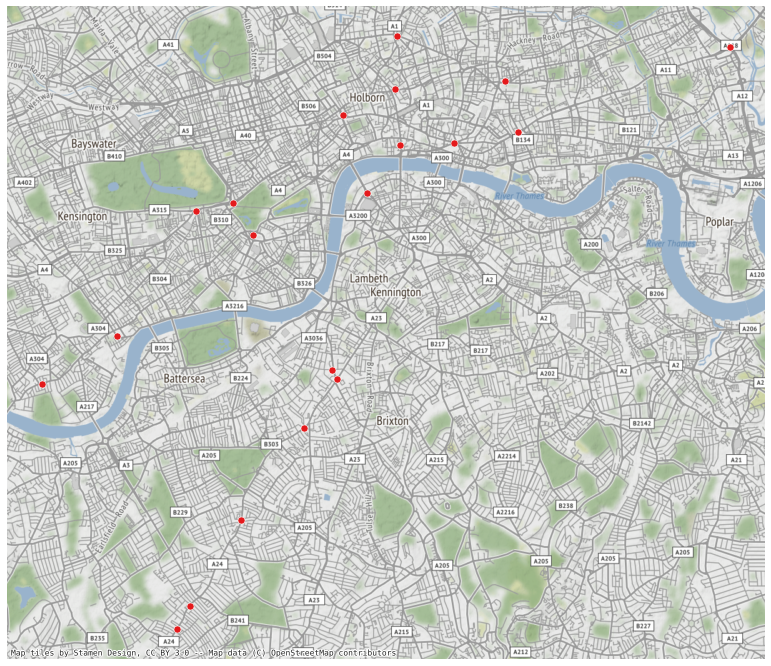

In [281]:
junction_stats = geopandas.GeoDataFrame(
    junction_stats,
    geometry=geopandas.points_from_xy(
        junction_stats.longitude_cluster,
        junction_stats.latitude_cluster,
        crs="EPSG:4326"
    )
)

junction_stats.to_crs(epsg=3857, inplace=True)

fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(
    x=junction_stats.geometry.x,
    y=junction_stats.geometry.y,
    s=50
);
sns.despine(left=True, bottom=True)
ax.set_xticks([])
ax.set_yticks([])
cx.add_basemap(ax)

## Interogate example

To show the benefit of this new way of structuring the junction data, let's look at the worst junction example.

Use folium so we can zoom in

In [288]:
worst_junction_cluster_ids = junction_stats['junction_cluster_id'].values[0:10]
example = junction_collisions[junction_collisions['junction_cluster_id'].isin(worst_junction_cluster_ids)]

mean_lat = example['latitude'].mean()
mean_lon = example['longitude'].mean()

m = Map(
    center=(mean_lat, mean_lon),
    zoom=12,
#     basemap=basemaps.Strava.Ride  # <- interesting, but slow!
    basemap=basemaps.CartoDB.Positron
)

for lon, lat in example[["longitude", "latitude"]].values:
    marker = Marker(location=(lat, lon), draggable=False)
    m.add_layer(marker)
    
m.layout.height="600px"

m

Map(center=[51.49775039855072, -0.11073573913043479], controls=(ZoomControl(options=['position', 'zoom_in_text…

Try create polygons..

In [289]:
import folium

example = geopandas.GeoDataFrame(
    example,
    geometry=geopandas.points_from_xy(
        example.longitude_junction,
        example.latitude_junction,
        crs="EPSG:4326"
    )
)

mean_lat = example['latitude_junction'].mean()
mean_lon = example['longitude_junction'].mean()

m = folium.Map(
    center=[mean_lat, mean_lon],
    basemap=basemaps.CartoDB.Positron
)

polygons = example.dissolve('junction_cluster_id').convex_hull
folium.GeoJson(polygons).add_to(m)
folium.LatLngPopup().add_to(m)

sw = example[['latitude_junction', 'longitude_junction']].min().values.tolist()
ne = example[['latitude_junction', 'longitude_junction']].max().values.tolist()
m.fit_bounds([sw, ne])

m

# Output data

Junctions data doesn't need to be output since it hasn't changed.

In [291]:
collisions = collisions[
    collisions['distance_to_junction'] <= distance_threshold
]

collisions.to_csv('../data/collisions.csv', index=False)
collisions.head()

,id,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,datetime,fatal_cyclist_casualties,serious_cyclist_casualties,slight_cyclist_casualties,danger_metric,recency_danger_metric,max_cyclist_severity,distance_to_junction,junction_index,junction_id
0,201101BS70212,2011,01BS70212,526820.0,177800.0,-0.174917,51.484887,Metropolitan Police,Serious,2,...,2011-05-23T06:19:00Z,0,1,0,1,0.0,serious,0.000076,14448.0,27512727
1,201101BS70227,2011,01BS70227,527690.0,179150.0,-0.161906,51.496824,Metropolitan Police,Serious,2,...,2011-05-24T07:23:00Z,0,1,0,1,0.0,serious,0.000124,12344.0,26592979
2,201101BS70277,2011,01BS70277,524710.0,180260.0,-0.204421,51.507464,Metropolitan Police,Serious,2,...,2011-06-22T06:30:00Z,0,1,0,1,0.0,serious,0.000076,40618.0,3936955037
3,201101BS70328,2011,01BS70328,524640.0,181190.0,-0.205100,51.515838,Metropolitan Police,Serious,2,...,2011-07-19T21:12:00Z,0,1,0,1,0.0,serious,0.000079,2054.0,275440
4,201101BS70329,2011,01BS70329,524700.0,180500.0,-0.204480,51.509624,Metropolitan Police,Serious,2,...,2011-07-05T06:15:00Z,0,1,0,1,0.0,serious,0.000041,44417.0,7342416727
